In [2]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

In [3]:
def select_model(input):
  source = {'CodeBERT_small' : {'tokenizer' : "huggingface/CodeBERTa-small-v1", 'model':"huggingface/CodeBERTa-small-v1"},
            'CodeBERT' : {'tokenizer' : "microsoft/codebert-base", 'model':"microsoft/codebert-base"},
            'GraphCodeBERT' : {'tokenizer' : "microsoft/graphcodebert-base", 'model':"microsoft/graphcodebert-base"},
            'Fine-tuning_Example' : {'tokenizer':"mrm8488/codebert-finetuned-clone-detection", 'model':"mrm8488/codebert-finetuned-clone-detection"}
  }
  
  if input in source.keys():
    tokenizer = source[input]['tokenizer']
    model = source[input]['model']
  else:
    print('Return None Obejects')
    print('Models :', source.keys())
    return None, None
  
  return tokenizer, model

In [4]:
tokenizer_path, model_path = select_model('CodeBERT')

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader

class Code():
    def __init__(self, path, test_size):
        self.path = path
        self.test_size = test_size
            
    def openFile(self):
        df = pd.read_csv(self.path+'sample_train.csv')
        df = df.sample(frac=1).reset_index(drop=True) # shuffle

        # dataframe to ndarray
        ndarray = pd.DataFrame.to_numpy(df)

        # train/valid/test
        train = ndarray[:-2*self.test_size]
        valid = ndarray[-2*self.test_size:-self.test_size]
        test = ndarray[-self.test_size:]

        return train, valid, test

class code_dataset(Dataset):
    def __init__(self, data):
        self.code1 = data[:, 0].tolist()
        self.code2 = data[:, 1].tolist()

        # token1
        tokens1 = tokenizer(self.code1, padding='max_length', truncation=True, return_tensors='pt')
        self.code1_tensor = tokens1['input_ids']
        self.code1_attn_mask = tokens1['attention_mask']
        # token2
        tokens2 = tokenizer(self.code2, padding='max_length', truncation=True, return_tensors='pt')
        self.code2_tensor = tokens2['input_ids']
        self.code2_attn_mask = tokens2['attention_mask']
        # label
        self.label = torch.from_numpy(data[:, 2].astype(float)).float()

    def __getitem__(self, index):
        return self.code1_tensor[index], self.code1_attn_mask[index], self.code2_tensor[index], self.code2_attn_mask[index], self.label[index]

    def __len__(self):
        return len(self.label)

def dataset_loader(path, test_size, batch_size):
    code = Code(path, test_size=test_size)

    train, valid, test = code.openFile()

    train_dataset = code_dataset(train)
    valid_dataset = code_dataset(valid)
    test_dataset = code_dataset(test)

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

    return train_loader, valid_loader, test_loader

def dataloader_testing():
    # dataloader test
    path = './'
    train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=3) # batch_size = 3 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data[0]))
    print('Code1 : ', type(data[0]),'\n', data[0])
    print('Code1_attn :', type(data[1]),'\n', data[1])
    print('Code2 : ', type(data[2]),'\n', data[2])
    print('Code2_attn :', type(data[3]),'\n', data[3])
    print('Labels :', type(data[4]),'\n', data[4])

In [6]:
dataloader_testing()

Batch Size : 3
Code1 :  <class 'torch.Tensor'> 
 tensor([[    0,   487,  5457,  ...,     1,     1,     1],
        [    0,  9232,  1049,  ...,     1,     1,     1],
        [    0, 10431,   328,  ...,     1,     1,     1]])
Code1_attn : <class 'torch.Tensor'> 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Code2 :  <class 'torch.Tensor'> 
 tensor([[    0,   282,  5457,  ...,     1,     1,     1],
        [    0, 20235,  1640,  ...,     1,     1,     1],
        [    0,  1178,   134,  ...,     1,     1,     1]])
Code2_attn : <class 'torch.Tensor'> 
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Labels : <class 'torch.Tensor'> 
 tensor([1., 0., 1.])


Fine-tuning

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# class FineTuningNet(nn.Module):
#     def __init__(self):
#         super(FineTuningNet, self).__init__()
#         self.codeBERT = AutoModel.from_pretrained(model_path, return_dict=False)
#         self.fc = nn.Linear(self.codeBERT.config.hidden_size, 768) # Fine-tuning Layer : 768 -> 768
#         # self.emb_dim = emb_dim

#     def forward(self, codes1_token, codes1_attn_mask, codes2_token, codes2_attn_mask):
#         emb1, cls1 = self.codeBERT(codes1_token, codes1_attn_mask) # intermediate embedding for code1 -> batch_size X emb_dim
#         emb2, cls2 = self.codeBERT(codes2_token, codes2_attn_mask) # intermediate embedding for code2 -> batch_size X emb_dim

#         mask1 = codes1_attn_mask.unsqueeze(-1).expand(emb1.size()).float()
#         mask2 = codes2_attn_mask.unsqueeze(-1).expand(emb2.size()).float()

#         masked_embs1 = emb1*mask1
#         masked_embs2 = emb2*mask2

#         summed1 = torch.sum(masked_embs1, 1)
#         summed2 = torch.sum(masked_embs2, 1)

#         sum_weight1 = torch.clamp(mask1.sum(1), min=1e-9)
#         sum_weight2 = torch.clamp(mask2.sum(1), min=1e-9)

#         mean_pooled1 = summed1/sum_weight1 # batch X emb_dim for code1s
#         mean_pooled2 = summed2/sum_weight2 # batch X emb_dim for code2s

#         code1_emb = mean_pooled1 # batch X emb_dim
#         code2_emb = mean_pooled2 # batch X emb_dim

#         # print(code1_emb.shape)
#         # print(code2_emb.shape)

#         imd1 = torch.tanh(self.fc(code1_emb)) # batch X emb_dim
#         imd2 = torch.tanh(self.fc(code2_emb)) # batch X emb_dim

#         cos_sim = F.cosine_similarity(imd1, imd2, dim=1) # batch
#         cos_sim = (cos_sim + 1)/2 # element-wise normalization ([-1,1] to [0,1])
#         # print(cos_sim.shape)
        
#         return cos_sim

class FineTuningNet(nn.Module):
    def __init__(self):
        super(FineTuningNet, self).__init__()
        self.codeBERT = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=False, num_labels=768)

    def forward(self, codes1_token, codes1_attn_mask, codes2_token, codes2_attn_mask):
        emb1 = self.codeBERT(codes1_token, token_type_ids=None, attention_mask=codes1_attn_mask)[0] # intermediate embedding for code1 -> batch_size X emb_dim
        emb2 = self.codeBERT(codes2_token, token_type_ids=None, attention_mask=codes2_attn_mask)[0] # intermediate embedding for code2 -> batch_size X emb_dim

        cos_sim = F.cosine_similarity(emb1, emb2, dim=1) # batch
        cos_sim = (cos_sim + 1)/2 # element-wise normalization ([-1,1] to [0,1])
        # print(cos_sim.shape)
        
        return cos_sim

In [8]:
path = './'
train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=16)

In [9]:
from tqdm import tqdm

model = FineTuningNet()

# for param in model.codeBERT.parameters(): 
#     param.requires_grad = False # trun-off CodeBERT update

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCELoss().to(device)
optimizer = optim.AdamW(model.parameters())

num_epochs = 1
loss_list = []

model = model.to(device)
model.train()

for epoch in range(num_epochs):
    
    with tqdm(train_loader, unit='batch') as progress:
        for (codes1_token, codes1_attn_mask, codes2_token, codes2_attn_mask, labels) in progress:
            progress.set_description(f"Epoch {epoch+1}")

            optimizer.zero_grad()

            codes1_token = codes1_token.to(device)
            codes2_token = codes2_token.to(device)
            # codes_token_stacked = torch.stack([codes1_token, codes2_token], dim=1)
            codes1_attn_mask = codes1_attn_mask.to(device)
            codes2_attn_mask = codes2_attn_mask.to(device)
            # codes_attn_mask_stacked = torch.stack([codes1_attn_mask, codes2_attn_mask], dim=1)
            labels = labels.to(device)

            outputs = model(codes1_token, codes1_attn_mask, codes2_token, codes2_attn_mask)

            # print(outputs)

            loss = loss_fn(outputs, labels)
            loss.backward()

            loss_list.append(loss.item())
            optimizer.step()

            progress.set_postfix(loss=loss.item())

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'step')

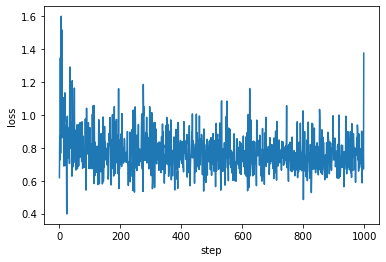

In [11]:
plt.plot(loss_list)
plt.ylabel('loss')
plt.xlabel('step')